<h1>Sinhala OCR Phase 1</h1>

<h3>1. Dataset Handling</h3>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [3]:
df_train = pd.read_csv('train.txt', sep=" ", header=None)
df_test = pd.read_csv('test.txt', sep=" ", header=None)

In [4]:
x_train_list = []
x_test_list = []

for i in range(len(df_train)):
    img_raw = cv2.imread('dataset/train/'+df_train[0][i], cv2.IMREAD_GRAYSCALE)
    img_inv = cv2.bitwise_not(img_raw)
    img_resized = cv2.resize(img_inv, (28, 28))
    x_train_list.append(img_resized/255.0)

for i in range(len(df_test)):
    img_raw = cv2.imread('dataset/train/'+df_train[0][i], cv2.IMREAD_GRAYSCALE)
    img_inv = cv2.bitwise_not(img_raw)
    img_resized = cv2.resize(img_inv, (28, 28))
    x_test_list.append(img_resized/255.0)

x_train = np.asarray(x_train_list, dtype=np.float32)
x_test = np.asarray(x_test_list, dtype=np.float32)

y_train = df_train[1].values
y_test = df_test[1].values

In [5]:
print("X Train Shape:", x_train.shape)
print("X Test Shape:", x_test.shape)

print("Y Train Shape:", y_train.shape)
print("Y Test Shape:", y_test.shape)

X Train Shape: (192, 28, 28)
X Test Shape: (32, 28, 28)
Y Train Shape: (192,)
Y Test Shape: (32,)


In [6]:
classes = ['ක', 'ඛ', 'ග', 'ඝ', 'ඟ', 'ච', 'ඡ', 'ජ', 'ට', 'ඩ', 'න', 'ණ', 'ත', 'ථ', 'ද',
           'ධ', 'ප', 'ඵ', 'බ', 'භ', 'ම', 'ඹ', 'ය', 'ර', 'ල', 'ව', 'ශ', 'ෂ', 'ස', 'හ', 'ළ', 'ෆ']

<h5>Sample Image</h5>

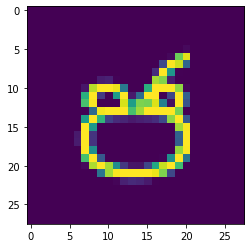

In [7]:
rand_int = np.random.randint(low=0, high=31)
sample_img_gray = cv2.imread('dataset/test/'+df_test[0][rand_int], cv2.IMREAD_GRAYSCALE)
sample_img_inv = cv2.bitwise_not(sample_img_gray)
sample_img_resized = cv2.resize(sample_img_inv, (28, 28))
plt.imshow(sample_img_resized)

<h3>2. Training</h3>

In [8]:
import tensorflow as tf

# Define a simple sequential model
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation=tf.nn.softmax)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [9]:
model = create_model()
model.fit(x_train, y_train, epochs=5)
loss, acc = model.evaluate(x_test, y_test)
print("Model Trained")
print("Loss:", loss)
print("Accuracy: {:5.2f}%".format(100 * acc))

# Save the weights
model.save_weights('model/my_checkpoint')
print("Model Saved")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 192 samples
Epoch 1/5
192/192 [==============================] - ETA: 0s - loss: 3.5866 - acc: 0.0000e+0 - 0s 551us/sample - loss: 3.4368 - acc: 0.0625
Epoch 2/5
192/192 [==============================] - 0s 156us/sample - loss: 2.8989 - acc: 0.3281
Epoch 3/5
192/192 [==============================] - 0s 166us/sample - loss: 2.4513 - acc: 0.5781
Epoch 4/5
192/192 [==============================] - 0s 161us/sample - loss: 2.0887 - acc: 0.6719
Epoch 5/5
32/32 [==============================] - 0s 810us/sample - loss: 0.9942 - acc: 0.9688
Model Trained
Loss: 0.9942002296447754
Accuracy: 96.88%
Model Saved


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                16416     
Total params: 418,336
Trainable params: 418,336
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Load model
# Create a new model instance
model = create_model()

# Restore the weights
model.load_weights('model/my_checkpoint')

# Evaluate the model
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - loss: 0.9942 - acc: 0.9688
Restored model, accuracy: 96.88%


<h3>3. Decode Image for OCR</h3>

In [12]:
from imutils import resize, grab_contours
from PIL import ImageFont, ImageDraw, Image

def read_img(img):
    image_to_test = cv2.imread(img)
    # convert to grayscale
    gray = cv2.cvtColor(image_to_test, cv2.COLOR_BGR2GRAY)
    # blurring the image
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # apply edge filter to the blurred image
    edge = cv2.Canny(blur, 30, 150)

    # get contours
    cntrs = cv2.findContours(
        edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntrs = grab_contours(cntrs)

    # sort contours from top left to bottom right
    boundingBox = [cv2.boundingRect(c) for c in cntrs]
    (cntrs, _) = zip(*sorted(zip(cntrs, boundingBox),
                             key=lambda x: (-x[1][1], x[1][0])))

    image_size = (28, 28)

    char_detected = []

    for c in cntrs:
        (x, y, w, h) = cv2.boundingRect(c)

        # attemp to ignore small contours
        if (w >= 32 and w <= 350) and (h >= 32 and h <= 320):
            # create an Region of Interest
            roi = gray[y:y+h, x:x+w]

            # threshold it to make it into binary image
            bin_img = cv2.threshold(
                roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            bin_img = cv2.copyMakeBorder(
                bin_img,
                top=10,
                bottom=10,
                left=10,
                right=10,
                borderType=cv2.BORDER_CONSTANT,
                value=0
            )
            (iH, iW) = bin_img.shape

            if iW > iH:
                bin_img = resize(bin_img, width=image_size[0])
            else:
                bin_img = resize(bin_img, height=image_size[1])

            # update with the new image size
            (iH, iW) = bin_img.shape
            dX = int(max(0, 32 - iW) / 2.0)
            dY = int(max(0, 32 - iH) / 2.0)

            # pad the image and resize it to match the input of the model
            padded = cv2.copyMakeBorder(bin_img, top=dY, bottom=dY,
                                        left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                                        value=(0, 0, 0))
            padded = cv2.resize(padded, image_size)

            # normalize the image so that it got the same value of testImg
            padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)

            # put it into list of the queue of images to predict
            char_detected.append([padded, (x, y, w, h)])

    # get each location and image of detected char
    boxes = [b[1] for b in char_detected]
    char_detected = np.array([c[0].reshape(28, 28)
                              for c in char_detected], dtype="float32")

    return char_detected, boxes, image_to_test

Letter ළ - 12.45%
Letter ද - 13.24%
Letter ස - 12.05%
Letter ල - 8.96%
Letter ස - 12.60%
Letter හ - 12.14%
Letter ව - 9.74%
Letter ර - 36.40%
Letter ක - 25.64%
Letter ද - 53.88%
Letter න - 20.95%
Letter ල - 8.50%
Letter ඛ - 21.32%
Letter ඹ - 14.42%
Letter ක - 47.68%
Letter ශ - 13.16%
Letter ණ - 29.76%
Letter ජ - 36.10%
Letter බ - 10.71%
Letter ඩ - 24.80%


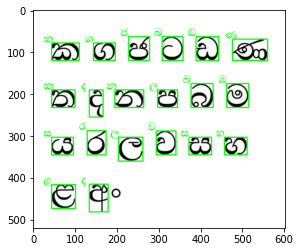

In [13]:
char_detected, boxes, img_ori = read_img('image.jpg')

predictions = model.predict(char_detected)
preds = []
for pred in predictions:
    i = np.argmax(pred)
    prob = pred[i]
    preds.append([classes[i], prob])

fontpath = "iskpota.ttf"
font = ImageFont.truetype(fontpath, 32)
b, g, r, a = 0, 255, 0, 0

for (pred, (x, y, w, h)) in zip(preds, boxes):
    # put the result into the image and print it
    print("Letter {} - {:.2f}%".format(pred[0], pred[1] * 100))
    cv2.rectangle(img_ori, (x, y), (x + w, y + h), (0, 255, 0), 2)

img_ori_raw = Image.fromarray(img_ori)
for (pred, (x, y, w, h)) in zip(preds, boxes):
    draw = ImageDraw.Draw(img_ori_raw)
    draw.text((x - 20, y - 30),
              "{}".format(pred[0]), font=font, fill=(b, g, r, a))

img = np.array(img_ori_raw)

plt.imshow(img)

In [13]:
# Save Image
cv2.imwrite("result.png", img)

True